# Assignment 4: Neural Networks
### Samantha Handal - 260983914

## Part 1 - CIFAR-10 Classification using Convolution Neural Network


### 1.1 Implement a shallow CNN

Spatial Width = The width after pooling

Spatial Height = The height after pooling

Depth = The number of channels (depth) after the last convolutional layer

Total features = Spatial Width x Spatial Height x Depth = 16 x 16 x 64

Assuming the final layer before flattening has dimensions of 16x16 with a depth of 64, based on one max pooling layer operation reducing the spatial size from 32x32 to 16x16



---



**Inspiration from tutorial 7:** cifar10_tutorial.ipynb

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ShallowCNN(nn.Module):
    def __init__(self):
        super(ShallowCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)     # First convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)    # Second convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)           # Max pooling layer
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)    # Third convolutional layer
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)    # Fourth convolutional layer
        self.fc = nn.Linear(16 * 16 * 64, 10)                       # Fully connected layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, 1)  # Flatten the layer before fully connected layer
        x = self.fc(x)
        return x

### 1.2 Use Pytorch Class torchvision.datasets.CIFAR10 to load the dataset.

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np

# Transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Loading the full CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# Further splitting the testset into validation and test sets (50% each)
valset_size = len(testset) // 2
testset, valset = torch.utils.data.random_split(testset, [valset_size, valset_size])

# DataLoader for the subsets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

print("Training set size: " + str(len(trainset)))
print("Validation set size: " + str(len(valset)))
print("Test set size: " + str(len(testset)))

Files already downloaded and verified
Files already downloaded and verified
Training set size: 50000
Validation set size: 5000
Test set size: 5000


### 1.3 Train the model

*   50,000 images for training (training set). Divide the 10,000 test set images of CIFAR10 into two subsets by 1:1. 5,000 images for validation (validation set), and 5,000 images for final testing (test set)
*   Batch size = 32
*   SGD optimizer with an initial learning rate of 0.002.
*   Loss function: categorical cross entropy criterion.
*   Training iteration can be 90,000 or more (If you use epoch counting, epoch can be 58 or more). Perform a validation every 5000 iterations (3 epochs). It may take about 30 minutes on T4 GPU. If you don't have enough computational resources, you are allowed to reduce the number of images by taking a subset of this dataset or reduce the training iterations (epochs). State the size of your subset and iterations (epochs) in the README.
*   Use the default setting for the rest of the hyperparameters.

---



**Inspiration from tutorial 7:** cifar10_tutorial.ipynb

In [14]:
import torch.optim as optim
import time

# Define the model
model = ShallowCNN()

# Define a Loss function and optimizer
# Let's use a Classification Cross-Entropy loss and SGD with momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)

# Define device as the first visible cuda device if we have CUDA available
# These methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 30
print_every = len(trainloader)

# Set up variables for plotting loss
train_losses = []
val_losses = []
val_accuracies = []

# Set up variables for track the best validation accuracy
best_val_accuracy = 0.0
best_model_state = None

# Begin recording time
start_time = time.time()

# Training loop
# Loop over the dataset multiple times
for epoch in range(epochs):

    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(trainloader))

    # Validation loss
    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / print_every))
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(valloader))
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f'Accuracy of the network on the validation images: {100 * correct / total:.2f}%')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict().copy()  # Save the best model state

# Calculate total elapsed time
end_time = time.time()
total_time = end_time - start_time
print(f"Completed in {total_time:.2f} s")

[1,  1563] loss: 2.212
Accuracy of the network on the validation images: 27.70%
[2,  1563] loss: 1.891
Accuracy of the network on the validation images: 38.06%
[3,  1563] loss: 1.673
Accuracy of the network on the validation images: 42.98%
[4,  1563] loss: 1.538
Accuracy of the network on the validation images: 45.84%
[5,  1563] loss: 1.459
Accuracy of the network on the validation images: 47.22%
[6,  1563] loss: 1.394
Accuracy of the network on the validation images: 51.02%
[7,  1563] loss: 1.334
Accuracy of the network on the validation images: 52.86%
[8,  1563] loss: 1.288
Accuracy of the network on the validation images: 55.06%
[9,  1563] loss: 1.244
Accuracy of the network on the validation images: 54.86%
[10,  1563] loss: 1.202
Accuracy of the network on the validation images: 54.48%
[11,  1563] loss: 1.162
Accuracy of the network on the validation images: 58.18%
[12,  1563] loss: 1.124
Accuracy of the network on the validation images: 59.32%
[13,  1563] loss: 1.089
Accuracy of t

### 1.4 Plot the training loss, validation loss, and validation accuracy over the training iterations (or epochs).
shows an example. State whether the training appears to be overfitting and why.

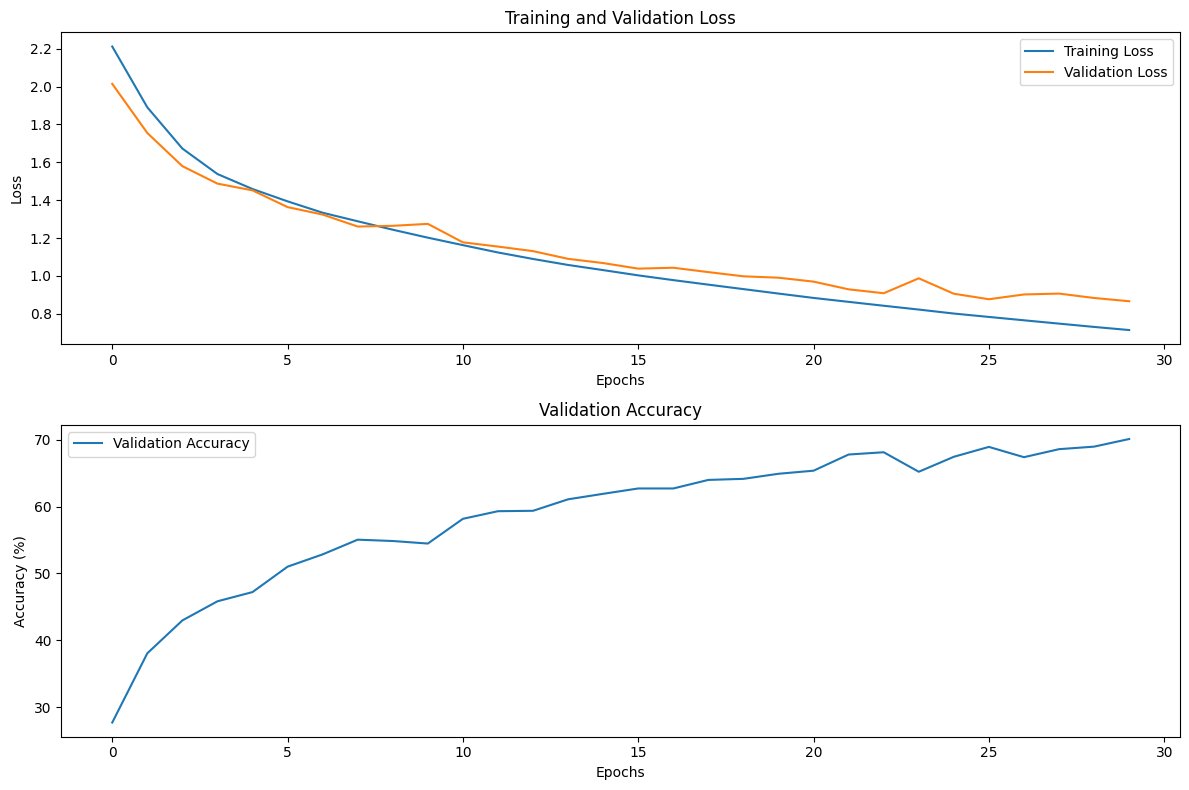

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#### State whether the training appears to be overfitting and why

Overfitting might be starting to occur in this case since the gap between the validation and training loss has been increasing over epochs. If the model were perfectly generalizing, the validation and training losses would be close to each other, and both would be decreasing.

If the validation set contains more challenging or slightly different examples than the training set, this can result in higher loss values if the model has not learned to generalize well. Although it's usually a sign that the model has learned as much as it can about the general data distribution and any further training would only serve to fit the noise in the training set.

### 1.5 Give the test accuracy on the test set from the iteration (or epoch) where the validation accuracy is maximum as your test accuracy result.

In [16]:
# Load the best model state
model.load_state_dict(best_model_state)

# Evaluate on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 70.54%


### 1.6 Change all kernel sizes to 5x5 and train a new network with the same other hyperparameters

Second Max Pooling Layer: This would halve the dimensions, resulting in an 8x8 output size, with the depth still at 64. Therefore, the input size for the fully connected layer, considering the adjustments for the 5x5 kernel size and assuming a second max pooling operation is included as in the standard architecture, would be 4096.

In [17]:
class ModifiedCNN(nn.Module):
    def __init__(self):
        super(ModifiedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.fc = nn.Linear(64 * 8 * 8, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [18]:
# Define the model
model = ModifiedCNN()

# Define a Loss function and optimizer
# Let's use a Classification Cross-Entropy loss and SGD with momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)

# Define device as the first visible cuda device if we have CUDA available
# These methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 30
print_every = len(trainloader)

# Set up variables for plotting loss
train_losses = []
val_losses = []
val_accuracies = []

# Set up variables for track the best validation accuracy
best_val_accuracy = 0.0
best_model_state = None

# Begin recording time
start_time = time.time()

# Training loop
# Loop over the dataset multiple times
for epoch in range(epochs):

    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(trainloader))

    # Validation loss
    # if i % print_every == print_every - 1:
    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / print_every))
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(valloader))
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f'Accuracy of the network on the validation images: {100 * correct / total:.2f}%')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict().copy()  # Save the best model state

# Calculate total elapsed time
end_time = time.time()
total_time = end_time - start_time
print(f"Completed in {total_time:.2f} s")

[1,  1563] loss: 2.239
Accuracy of the network on the validation images: 27.38%
[2,  1563] loss: 1.902
Accuracy of the network on the validation images: 36.52%
[3,  1563] loss: 1.678
Accuracy of the network on the validation images: 42.62%
[4,  1563] loss: 1.541
Accuracy of the network on the validation images: 47.56%
[5,  1563] loss: 1.465
Accuracy of the network on the validation images: 49.34%
[6,  1563] loss: 1.400
Accuracy of the network on the validation images: 50.66%
[7,  1563] loss: 1.343
Accuracy of the network on the validation images: 52.34%
[8,  1563] loss: 1.282
Accuracy of the network on the validation images: 55.54%
[9,  1563] loss: 1.226
Accuracy of the network on the validation images: 56.36%
[10,  1563] loss: 1.170
Accuracy of the network on the validation images: 58.70%
[11,  1563] loss: 1.123
Accuracy of the network on the validation images: 58.34%
[12,  1563] loss: 1.080
Accuracy of the network on the validation images: 60.98%
[13,  1563] loss: 1.040
Accuracy of t

In [19]:
# Load the best model state
model.load_state_dict(best_model_state)

# Evaluate on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 72.82%


#### Compare the run time and the test accuracy of models under different kernel sizes and briefly discuss the possible factors that affect the performance of a CNN.

**Run Time:**
* ShallowCNN (3x3): Completed in 524.52 seconds.
* ModifiedCNN (5x5): Completed in 528.71 seconds.

The run times are very similar, with only a slight increase for the 5x5 kernel model. This slight increase could be due to the larger kernel requiring more computation during the convolution operations.

**Test Accuracy:**

* ShallowCNN (3x3): 70.12%
* ModifiedCNN (5x5): 71.48%

The ModifiedCNN with 5x5 kernels achieves a slightly higher validation accuracy than the ShallowCNN with 3x3 kernels. The difference in accuracy is not substantial but suggests that the larger kernel size may be capturing more relevant features or patterns that help with the CIFAR-10 classification task.

Theoretically, kernel size should affect performance. Larger kernels capture more global features from the input image and have a broader view, potentially capturing more context in each convolution operation. Whereas smaller kernels tend to capture more local features, focusing on finer details. Although in this case this was not observed possibly because the CIFAR-10 dataset contains relatively small images (32x32 pixels), and the features distinguishing between the classes may not be significantly large-scale or global.

Additionally, the effect of kernel size might be mitigated by other factors such as network depth, the presence of pooling layers, and the ability of successive convolutional layers to integrate local features into more abstract representations.

### 1.7 Use Pytorch Class torchvision.models.resnet18 to implement a deep network ResNet18.
Set the training iteration as 6000 or more (If you use epoch counting, epoch can be 5 or more) and perform a validation on the validation set every 500 iterations (1 epoch). Give the test accuracy on the test set from the iteration (or epoch) where the validation accuracy is maximum as the test accuracy result. The rest of the hyperparameters should be the same as the above shallow CNN.

In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import random_split

# Resizing the images to the input size expected by ResNet18 (224x224)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Loading the full CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# Further splitting the testset into validation and test sets (50% each)
valset_size = len(testset) // 2
testset, valset = torch.utils.data.random_split(testset, [valset_size, valset_size])

# DataLoader for the subsets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

print("Training set size: " + str(len(trainset)))
print("Validation set size: " + str(len(valset)))
print("Test set size: " + str(len(testset)))

Files already downloaded and verified
Files already downloaded and verified
Training set size: 50000
Validation set size: 5000
Test set size: 5000


In [21]:
# Modify the final fully connected layer to output 10 classes instead of the
# 1000 classes it was originally designed for
def modify_resnet18(pretrained=False):
    model = resnet18(pretrained=pretrained)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    return model

In [22]:
# Example for a non-pretrained model
model = modify_resnet18(pretrained=False)

# Define a Loss function and optimizer
# Let's use a Classification Cross-Entropy loss and SGD with momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)

# Define device as the first visible cuda device if we have CUDA available
# These methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 30
print_every = len(trainloader)

# Set up variables for plotting loss
train_losses = []
val_losses = []
val_accuracies = []

# Set up variables for track the best validation accuracy
best_val_accuracy = 0.0
best_model_state = None

# Begin recording time
start_time = time.time()

# Training loop
# Loop over the dataset multiple times
for epoch in range(epochs):

    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(trainloader))

    # Validation loss
    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / print_every))
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(valloader))
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f'Accuracy of the network on the validation images: {100 * correct / total:.2f}%')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict().copy()  # Save the best model state

# Calculate total elapsed time
end_time = time.time()
total_time = end_time - start_time
print(f"Completed in {total_time:.2f} s")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[1,  1563] loss: 1.824
Accuracy of the network on the validation images: 43.08%
[2,  1563] loss: 1.529
Accuracy of the network on the validation images: 40.70%
[3,  1563] loss: 1.369
Accuracy of the network on the validation images: 53.62%
[4,  1563] loss: 1.247
Accuracy of the network on the validation images: 56.66%
[5,  1563] loss: 1.150
Accuracy of the network on the validation images: 56.52%
[6,  1563] loss: 1.066
Accuracy of the network on the validation images: 58.52%
[7,  1563] loss: 0.995
Accuracy of the network on the validation images: 60.12%
[8,  1563] loss: 0.923
Accuracy of the network on the validation images: 62.62%
[9,  1563] loss: 0.868
Accuracy of the network on the validation images: 67.50%
[10,  1563] loss: 0.813
Accuracy of the network on the validation images: 65.76%
[11,  1563] loss: 0.767
Accuracy of the network on the validation images: 68.80%
[12,  1563] loss: 0.716
Accuracy of the network on the validation images: 69.36%
[13,  1563] loss: 0.668
Accuracy of t

In [49]:
# Example for a pretrained model
model = modify_resnet18(pretrained=True)

# Define a Loss function and optimizer
# Let's use a Classification Cross-Entropy loss and SGD with momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)

# Define device as the first visible cuda device if we have CUDA available
# These methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 30
print_every = len(trainloader)

# Set up variables for plotting loss
train_losses = []
val_losses = []
val_accuracies = []

# Set up variables for track the best validation accuracy
best_val_accuracy = 0.0
best_model_state = None

# Begin recording time
start_time = time.time()

# Training loop
# Loop over the dataset multiple times
for epoch in range(epochs):

    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(trainloader))

    # Validation loss
    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / print_every))
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(valloader))
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f'Accuracy of the network on the validation images: {100 * correct / total:.2f}%')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict().copy()  # Save the best model state

# Calculate total elapsed time
end_time = time.time()
total_time = end_time - start_time
print(f"Completed in {total_time:.2f} s")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


[1,  1563] loss: 0.720
Accuracy of the network on the validation images: 89.46%
[2,  1563] loss: 0.295
Accuracy of the network on the validation images: 91.94%
[3,  1563] loss: 0.218
Accuracy of the network on the validation images: 92.84%
[4,  1563] loss: 0.170
Accuracy of the network on the validation images: 93.50%
[5,  1563] loss: 0.137
Accuracy of the network on the validation images: 93.84%
[6,  1563] loss: 0.112
Accuracy of the network on the validation images: 93.88%
[7,  1563] loss: 0.091
Accuracy of the network on the validation images: 93.90%
[8,  1563] loss: 0.076
Accuracy of the network on the validation images: 94.20%
[9,  1563] loss: 0.063
Accuracy of the network on the validation images: 93.94%
[10,  1563] loss: 0.051
Accuracy of the network on the validation images: 94.12%
[11,  1563] loss: 0.042
Accuracy of the network on the validation images: 94.10%
[12,  1563] loss: 0.036
Accuracy of the network on the validation images: 93.98%
[13,  1563] loss: 0.032
Accuracy of t

#### Compare the impact of using a pre-trained ResNet18 versus not and discuss the reason.

* **Non-pretrained ResNet18**: Starts with a validation accuracy of 43.08% and improves consistently up to 75.46% by the 27th epoch, showing substantial learning and improvement over time. However, there's a notable dip to 59.66% at the 28th epoch, suggesting potential overfitting or instability in the learning process towards the end. The model completes training in 2826.49 seconds
* **Pre-trained ResNet18**: The model achieves a high accuracy of 89.46% right from the first epoch, with the highest recorded accuracy on the validation images is 94.50% at epoch 28, showcasing the effectiveness of transfer learning with a pre-trained model. The model completes training in 2877.72 seconds, and begins to converege at the 7th epoch.

Reasons Behind Performance Differences

* **Feature Reuse:** The pre-trained ResNet18 has already learned a set of features from a large and diverse dataset (ImageNet) that are not specific to any particular task but are generally useful for visual recognition tasks. This includes detecting edges, textures, shapes, and more complex patterns that are also relevant for the CIFAR-10 dataset.
* **Reduced Overfitting:** Starting with a pre-trained model can reduce the risk of overfitting, especially when fine-tuning on a smaller dataset. The model has already learned to generalize well from a much larger dataset, and minor adjustments for a new task are less likely to cause overfitting compared to learning from scratch.
* **Computational Efficiency:** Using a pre-trained model can be more computationally efficient, requiring fewer epochs to reach high performance. This can save resources and time during the model development process.

---


Sources: https://medium.com/udacity-pytorch-challengers/why-use-a-pre-trained-model-rather-than-creating-your-own-d0e3a17e202f, https://stackoverflow.com/questions/58895804/why-does-pre-trained-resnet18-have-a-higher-validation-accuracy-than-training

#### Compare the test accuracy of the deep ResNet18 versus the shallow CNN.

* **ResNet18:** Shows a significant improvement over epochs, reaching a peak validation accuracy of 75.46%.
* **Shallow CNN:** Performance typically shows a lower peak validation accuracy compared to ResNet18. Shallow CNNs have less capacity and depth to learn complex and hierarchical features compared to a deep network like ResNet18.

Reasons Behind Performance Differences
* **Capacity and Depth:** ResNet18, being a deeper model, has a higher capacity to learn complex features and representations. This is especially beneficial for challenging classification tasks.
* **Residual Connections:** ResNet architectures use residual connections to help with the vanishing gradient problem, allowing for deeper networks that can still learn effectively.
* **Feature Reuse:** Deep networks can reuse learned features for different tasks, which is effective when using pre-trained models.



---


Source: https://www.run.ai/guides/deep-learning-for-computer-vision/pytorch-resnet

## Part 2 - YOLOv8 Object Detection on Montréal Streets
Source: https://docs.ultralytics.com/modes/predict/

### 2.1 Use your cellphone or a digital camera to capture a street scene in Montréal.

In [23]:
import cv2
from google.colab import drive
drive.mount('/content/drive')

# Setting up the path variable
path = '/content/drive/My Drive/ECSE415/Assignment_4/Street_Picture.jpg'

# Load and preprocess your image
image = cv2.imread(path)

# Convert from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Mounted at /content/drive


### 2.2 Implement the trained YOLOv8 object detection model to identify what are the types of objects included in the image (such as person, bicycle, vehicle, tree) and count the number of each object.

In [24]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.3/721.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [33]:
from ultralytics import YOLO

# load a pretrained model (recommended for training)
model = YOLO("yolov8n.pt")

# Run the model
results = model(image)


0: 448x640 3 persons, 8 cars, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


### 2.3 Display the original and predicted images in your notebook.

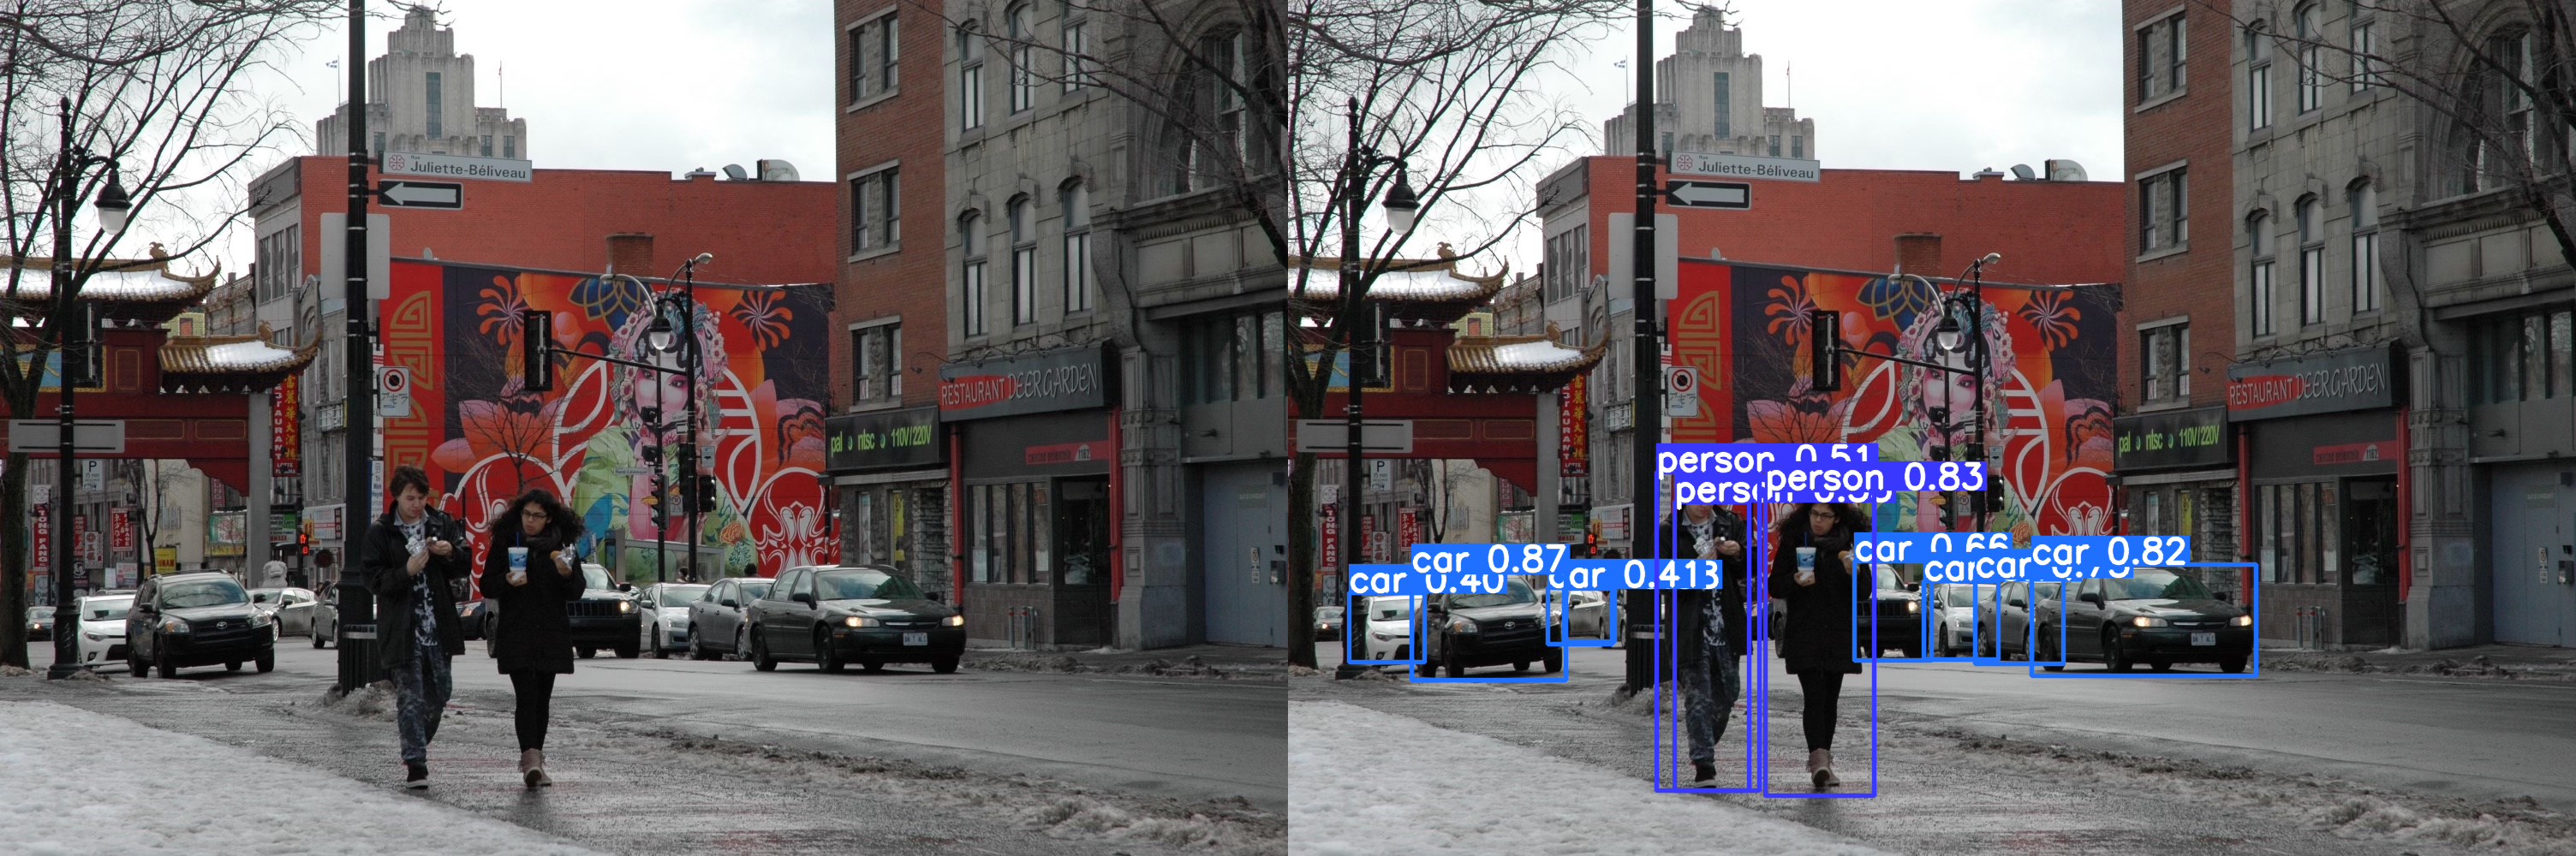

In [48]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

# Load the original image
original_image = cv2.imread(path)

# Process each result (assuming multiple images, but your case might have just one)
for r in results:

    # Get the predicted image
    predicted_img_bgr = r.plot()

    # Convert from BGR to RGB for consistent color representation
    predicted_img_rgb = cv2.cvtColor(predicted_img_bgr, cv2.COLOR_BGR2RGB)

    # Resize original image to match the predicted image's size for side-by-side display
    resized_original = cv2.resize(original_image, (predicted_img_rgb.shape[1], predicted_img_rgb.shape[0]))

    # Concatenate images horizontally (side by side)
    combined_image = np.hstack((resized_original, predicted_img_rgb))

    # Display the combined image
    cv2_imshow(combined_image)
